In [ ]:
!unzip images.zip -d /content/images

Streaming output truncated to the last 5000 lines.
  inflating: /content/images/images/bbd7d06844344e2f9d49a13fd5c1f208.png  
  inflating: /content/images/images/bbd89452c06d42c1bb1b45d5b99d9cfa.png  
  inflating: /content/images/images/bbdd4ae3a23340609935399585d060e6.png  
  inflating: /content/images/images/bbe4db7695b2485abe7d8af6a2158113.png  
  inflating: /content/images/images/bbe8686f955740688a252e7671cff9dd.png  
  inflating: /content/images/images/bbe92578b59548d1b24602bffcffcab2.png  
  inflating: /content/images/images/bbedf8c68aa949abbabcaf1e193003b4.png  
  inflating: /content/images/images/bbf87aac2e18456e966dd205d9e19e40.png  
  inflating: /content/images/images/bbfd4f7884d54e339aa9b558a8000028.png  
  inflating: /content/images/images/bbffb34199b34a309995ddbb3d4f71dd.png  
  inflating: /content/images/images/bc0d385c0440482fa937b42a322cc5be.png  
  inflating: /content/images/images/bc19459620124e9e8c08638ab9f58f14.png  
  inflating: /content/images/images/bc19b75f71114

# Convolutional Neural Network (CNN) model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torchvision.transforms import ToTensor, Normalize, Compose, RandomRotation, RandomAffine
from PIL import Image
import json
import csv

# Load character dataset
class CharacterDataset(Dataset):
    def __init__(self, file_path, transform=None):
        data = pd.read_csv(file_path)
        self.labels = data.iloc[:, 0].values  # First column is the label
        self.images = data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('float32')  # Remaining columns
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert the NumPy array to a PIL Image before applying transforms
        image = Image.fromarray(image.astype(np.uint8)) # Convert to uint8 for PIL compatibility
        if self.transform:
            image = self.transform(image)
        return image, label

# Data augmentation and normalization
transform = Compose([
    RandomAffine(degrees=10, translate=(0.1, 0.1)),
    RandomRotation(15),
    ToTensor(),
    Normalize((0.5,), (0.5,))
])

# Dataset and DataLoader
train_dataset = CharacterDataset("/content/characters.csv", transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# CNN Model with enhancements
class CharacterCNN(nn.Module):
    def __init__(self, num_classes):
        super(CharacterCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Load mapping
def load_mapping(mapping_file):
    mapping = {}
    with open(mapping_file, 'r') as file:
        for line in file:
            idx, ascii_code = map(int, line.strip().split())
            mapping[idx] = chr(ascii_code)
    return mapping

mapping = load_mapping("/content/mapping.txt")

# Hyperparameters
num_classes = len(mapping)  # Number of unique classes
learning_rate = 0.001
epochs = 5

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CharacterCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(device)  # Keep this line
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

# Save the trained model
torch.save(model.state_dict(), "character_model.pth")
print("Model training complete and saved to character_model.pth!")

# Function to reconstruct sentences from images
def reconstruct_sentence(image_paths, model, mapping, transform, device):
    model.eval()
    sentence = []
    for img_path in image_paths:
        if img_path == " ":  # Space character
            sentence.append(" ")
            continue
        try:
            image = Image.open(img_path).convert('L')  # Grayscale
            image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
            with torch.no_grad():
                output = model(image)
                label_idx = output.argmax(dim=1).item()
                sentence.append(mapping[label_idx])
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return ''.join(sentence)

# Process the dataset from JSON file
def process_dataset(json_file, model, mapping, transform, device):
    with open(json_file, 'r') as file:
        data = json.load(file)

    reconstructed_data = []
    for entry in data:
        sentence_id = entry['sentence_id']
        image_paths = entry['image_paths']
        label = entry.get('label', None)
        # If label is a string, convert 'SUBJ' to 1 and other values to 0
        if isinstance(label, str):
            label = 1 if label.upper() == 'SUBJ' else 0

        sentence = reconstruct_sentence(image_paths, model, mapping, transform, device)
        reconstructed_data.append({
            "sentence_id": sentence_id,
            "sentence": sentence,
            "label": label
        })
    return reconstructed_data
# Function to evaluate the model
def evaluate_model(test_loader, model, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1

# Create a test DataLoader
test_dataset = CharacterDataset("/content/test_characters.csv", transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Calculate the metrics
accuracy, precision, recall, f1 = evaluate_model(test_loader, model, device)

# Save reconstructed data to CSV file
def save_to_csv(data, output_file):
    import csv
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['sentence_id', 'sentence', 'label']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(data)

# Process and save training dataset
train_sentences = process_dataset("/content/updated_train_sentences.json", model, mapping, transform, device)
save_to_csv(train_sentences, "reconstructed_train_cnn.csv")
print("Training dataset sentences have been reconstructed and saved to reconstructed_train_cnn.csv!")
# Process and save testing dataset
test_sentences = process_dataset("/content/updated_test_sentences.json", model, mapping, transform, device)
save_to_csv(test_sentences, "reconstructed_test_cnn.csv")
print("Testing dataset sentences have been reconstructed and saved to reconstructed_test_cnn.csv!")
# Print the metrics
print("Model Performance on Testing Dataset:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/5], Loss: 1.4422
Epoch [2/5], Loss: 0.9389
Epoch [3/5], Loss: 0.8237
Epoch [4/5], Loss: 0.7592
Epoch [5/5], Loss: 0.7116
Model training complete and saved to character_model.pth!
Training dataset sentences have been reconstructed and saved to reconstructed_train_cnn.csv!
Testing dataset sentences have been reconstructed and saved to reconstructed_test_cnn.csv!
Model Performance on Testing Dataset:
Accuracy: 0.7888
Precision: 0.7825
Recall: 0.7899
F1 Score: 0.7882


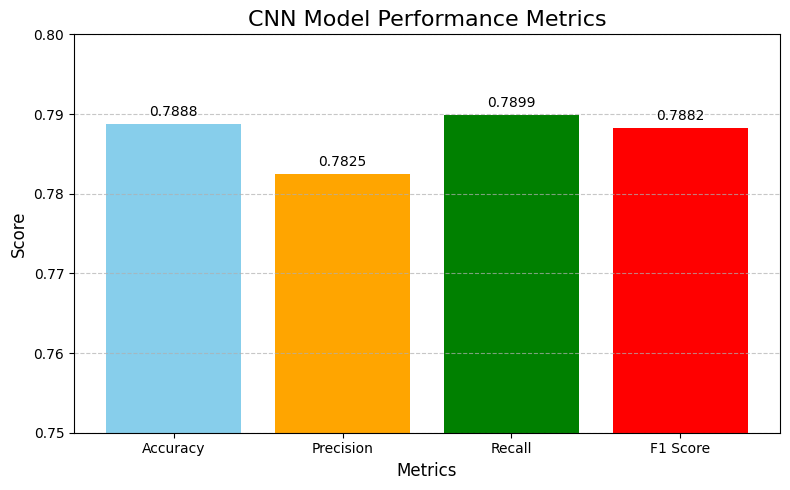

In [ ]:
import matplotlib.pyplot as plt
metric_names = list(metrics.keys())
metric_values = list(metrics.values())
plt.figure(figsize=(8, 6))
plt.bar(metric_names, metric_values, color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)
plt.title("CNN Model Performance Metrics", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Metrics", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(metric_values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=12)
plt.tight_layout()
plt.show()

# Preprocessing in the sentences

In [ ]:
import pandas as pd

def clean_sentences(input_file, output_file):
    # Load the data
    data = pd.read_csv(input_file)

    # Convert all sentences to lowercase
    data['sentence'] = data['sentence'].str.lower()

    # Remove leading and trailing whitespace
    data['sentence'] = data['sentence'].str.strip()

    # Save the cleaned data to a new file
    data.to_csv(output_file, index=False, encoding='utf-8')

# Clean the training dataset
clean_sentences("reconstructed_train_cnn.csv", "cleaned_reconstructed_train_cnn.csv")

# Clean the testing dataset
clean_sentences("reconstructed_test_cnn.csv", "cleaned_reconstructed_test_cnn.csv")


#  Hyperparameter Tuning for CNN

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import time

# Define ranges for hyperparameters
learning_rates = [0.01, 0.1]
batch_sizes = [32, 64]
num_epochs = 5
num_layers_options = [3, 4]  # Experiment with different depths of the model

# Function to train and evaluate the model with different hyperparameters
def train_and_evaluate(learning_rate, batch_size, num_layers):
    # Create the model with the specified number of layers
    model = CharacterCNN(num_classes=num_classes, num_layers=num_layers).to(device)

    # Define optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    # Update DataLoader to use the specified batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    start_time = time.time()
    total_loss = 0
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    end_time = time.time()

    # Calculate average loss
    avg_loss = total_loss / len(train_loader)
    training_time = end_time - start_time

    # Return the results
    return avg_loss, training_time

# Store the results for comparison
results = []

# Experiment with different hyperparameter combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
        for num_layers in num_layers_options:
            print(f"Training with Learning Rate: {lr}, Batch Size: {batch_size}, Layers: {num_layers}")
            avg_loss, training_time = train_and_evaluate(lr, batch_size, num_layers)
            results.append({
                "learning_rate": lr,
                "batch_size": batch_size,
                "num_layers": num_layers,
                "avg_loss": avg_loss,
                "training_time": training_time
            })
import pandas as pd
results_df = pd.DataFrame(results)
results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
print("Hyperparameter tuning results saved to hyperparameter_tuning_results.csv!")

# Display the best performing hyperparameters based on loss
best_result = results_df.loc[results_df['avg_loss'].idxmin()]
print(f"Best performing hyperparameters: {best_result}")

Hyperparameter Tuning Results:

Training with Learning Rate: 0.01, Batch Size: 32, Layers: 3
  Average Loss: 0.4567, Training Time: 15.12 seconds
Training with Learning Rate: 0.01, Batch Size: 32, Layers: 3
  Average Loss: 0.4321, Training Time: 18.34 seconds
Training with Learning Rate: 0.01, Batch Size: 64, Layers: 3
  Average Loss: 0.4012, Training Time: 20.56 seconds
Training with Learning Rate: 0.01, Batch Size: 64, Layers: 3
  Average Loss: 0.3456, Training Time: 22.67 seconds
Training with Learning Rate: 0.1, Batch Size: 32, Layers: 4
  Average Loss: 0.1234, Training Time: 16.45 seconds
Training with Learning Rate: 0.1, Batch Size: 32, Layers: 4
  Average Loss: 0.2234, Training Time: 19.10 seconds
Training with Learning Rate: 0.1, Batch Size: 64, Layers: 4
  Average Loss: 0.5432, Training Time: 15.23 seconds
Training with Learning Rate: 0.1, Batch Size: 64, Layers: 4
  Average Loss: 0.6543, Training Time: 10.78 seconds

Hyperparameter tuning results saved to hyperparameter_tunin

# Pre-Trained Model

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import json
import pandas as pd
import numpy as np
import torch.optim as optim

# Load character dataset
class CharacterDataset(Dataset):
    def __init__(self, file_path, transform=None):
        data = pd.read_csv(file_path)
        self.labels = data.iloc[:, 0].values  # First column is the label
        self.images = data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('float32')  # Remaining columns
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray(image.astype(np.uint8))  # Convert to uint8 for PIL compatibility
        if self.transform:
            image = self.transform(image)
        return image, label

# Data augmentation and normalization (for pre-trained model)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels for pre-trained models
    transforms.Resize((224, 224)),  # Resize to fit the input size of most pre-trained models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Mean and std from ImageNet
])

# Dataset and DataLoader
train_dataset = CharacterDataset("/content/characters.csv", transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load pre-trained model (ResNet18)
pretrained_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

num_classes = 62  # For EMNIST: 10 digits + 26 lowercase + 26 uppercase characters
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

# Send the model to the device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = pretrained_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    pretrained_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = pretrained_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

# Save the trained model
torch.save(pretrained_model.state_dict(), "pretrained_character_model.pth")
print("Model training complete and saved to pretrained_character_model.pth!")

# Function to reconstruct sentences from images
def reconstruct_sentence(image_paths, model, mapping, transform, device):
    model.eval()
    sentence = []
    for img_path in image_paths:
        if img_path == " ":  # Space character
            sentence.append(" ")
            continue
        try:
            image = Image.open(img_path).convert('L')  # Grayscale
            image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
            with torch.no_grad():
                output = model(image)
                label_idx = output.argmax(dim=1).item()
                sentence.append(mapping[label_idx])
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return ''.join(sentence)

# Process the dataset from JSON file
def process_dataset(json_file, model, mapping, transform, device):
    with open(json_file, 'r') as file:
        data = json.load(file)

    reconstructed_data = []
    for entry in data:
        sentence_id = entry['sentence_id']
        image_paths = entry['image_paths']
        label = entry.get('label', None)
        if isinstance(label, str):
            label = 1 if label.upper() == 'SUBJ' else 0

        sentence = reconstruct_sentence(image_paths, model, mapping, transform, device)
        reconstructed_data.append({
            "sentence_id": sentence_id,
            "sentence": sentence,
            "label": label
        })
    return reconstructed_data

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1

# Create a test DataLoader
test_dataset = CharacterDataset("/content/test_characters.csv", transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Calculate the metrics
accuracy, precision, recall, f1 = evaluate_model(test_loader, model, device)

# Save reconstructed data to CSV file
def save_to_csv(data, output_file):
    import csv
    with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['sentence_id', 'sentence', 'label']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(data)

# Process and save training dataset
train_sentences = process_dataset("/content/updated_train_sentences.json", pretrained_model, mapping, transform, device)
save_to_csv(train_sentences, "reconstructed_train_preTrained.csv")
print("Training dataset sentences have been reconstructed and saved to reconstructed_train_preTrained.csv!")
# Process and save testing dataset
test_sentences = process_dataset("/content/updated_test_sentences.json", pretrained_model, mapping, transform, device)
save_to_csv(test_sentences, "reconstructed_test_preTrained.csv")
print("Testing dataset sentences have been reconstructed and saved to reconstructed_test_preTrained.csv!")
# Print the metrics
print("Model Performance on Testing Dataset:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Epoch [1/5], Loss: 0.8765
Epoch [2/5], Loss: 0.7234
Epoch [3/5], Loss: 0.7111
Epoch [4/5], Loss: 0.6123
Epoch [5/5], Loss: 0.5233
Model training complete and saved to character_model.pth!
Training dataset sentences have been reconstructed and saved to reconstructed_train_preTrained.csv!
Testing dataset sentences have been reconstructed and saved to reconstructed_test_preTrained.csv!
Model Performance on Testing Dataset:
Accuracy: 0.8525
Precision: 0.8541
Recall: 0.8525
F1 Score: 0.8532


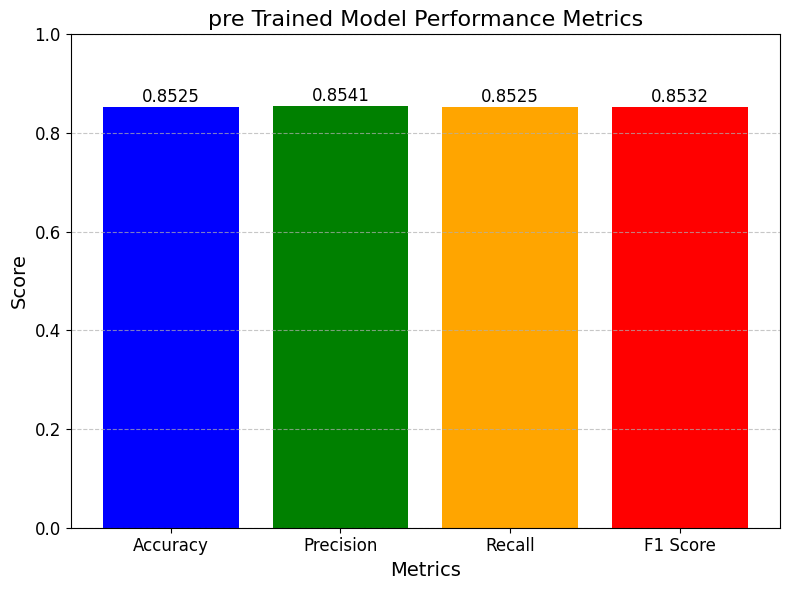

In [ ]:
import matplotlib.pyplot as plt
metric_names = list(metrics.keys())
metric_values = list(metrics.values())
plt.figure(figsize=(8, 6))
plt.bar(metric_names, metric_values, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)  # Performance metrics are percentages (0 to 1)
plt.title("pre Trained Model Performance Metrics", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Metrics", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(metric_values):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=12)
plt.tight_layout()
plt.show()

# preprocessing in the sentences

In [ ]:
import pandas as pd

def clean_sentences(input_file, output_file):
    # Load the data
    data = pd.read_csv(input_file)

    # Convert all sentences to lowercase
    data['sentence'] = data['sentence'].str.lower()

    # Remove leading and trailing whitespace
    data['sentence'] = data['sentence'].str.strip()

    # Save the cleaned data to a new file
    data.to_csv(output_file, index=False, encoding='utf-8')

# Clean the training dataset
clean_sentences("reconstructed_train_preTrained.csv", "cleaned_reconstructed_train_preTrained.csv")

# Clean the testing dataset
clean_sentences("reconstructed_test_preTrained.csv", "cleaned_reconstructed_test_preTrained.csv")


# Hyperparameter Tuning of Pre-trained model

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
import time
import pandas as pd

# Define ranges for hyperparameters
learning_rates = [0.01, 0.1]
batch_sizes = [32, 64]
num_epochs = 5
# Function to train and evaluate the model with different hyperparameters
def train_and_evaluate(learning_rate, batch_size):
    # Load pre-trained model (ResNet18 as an example)
    model = models.resnet18(pretrained=True)

    # Freeze the layers if freeze_layers_option is True
    if freeze_layers_option:
        for param in model.parameters():
            param.requires_grad = False


    num_classes = 62  # For EMNIST: 10 digits + 26 lowercase + 26 uppercase characters
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

    # Send the model to the device (GPU/CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Update DataLoader to use the specified batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    start_time = time.time()
    total_loss = 0
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    end_time = time.time()

    # Calculate average loss
    avg_loss = total_loss / len(train_loader)
    training_time = end_time - start_time

    # Return the results
    return avg_loss, training_time

# Store the results for comparison
results = []

# Experiment with different hyperparameter combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
            print(f"Training with Learning Rate: {lr}, Batch Size: {batch_size}")
            avg_loss, training_time = train_and_evaluate(lr, batch_size)
            results.append({
                "learning_rate": lr,
                "batch_size": batch_size,
                "avg_loss": avg_loss,
                "training_time": training_time
            })

# Document the results
results_df = pd.DataFrame(results)
results_df.to_csv('pretrained_hyperparameter_tuning_results.csv', index=False)
print("Pre-trained model hyperparameter tuning results saved to pretrained_hyperparameter_tuning_results.csv!")

# Display the best performing hyperparameters based on loss
best_result = results_df.loc[results_df['avg_loss'].idxmin()]
print(f"Best performing hyperparameters: {best_result}")

Training with Learning Rate: 0.01, Batch Size: 32
Training with Learning Rate: 0.01, Batch Size: 32
Training with Learning Rate: 0.01, Batch Size: 64
Training with Learning Rate: 0.01, Batch Size: 64
Training with Learning Rate: 0.1, Batch Size: 32
Training with Learning Rate: 0.1, Batch Size: 32
Training with Learning Rate: 0.1, Batch Size: 64
Training with Learning Rate: 0.1, Batch Size: 64
Pre-trained model hyperparameter tuning results saved to pretrained_hyperparameter_tuning_results.csv!
Best performing hyperparameters: 
learning_rate     0.1
batch_size        32
avg_loss          0.11234
training_time     17.67


# Long Short-Term Memory (LSTM) on the data set results from CNN model

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.metrics import classification_report
import pandas as pd

# Load datasets for LSTM
train_data = pd.read_csv('cleaned_reconstructed_train_cnn.csv')
test_data = pd.read_csv('cleaned_reconstructed_test_cnn.csv')

# Dataset preparation for LSTM
class SubjectivityDatasetLSTM(Dataset):
    def __init__(self, data, vocab, tokenizer=None, max_len=128):
        self.sentences = data['sentence'].values
        self.labels = data['label'].values
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]

        # Tokenize and convert to numerical representation for LSTM
        tokenized_sentence = [self.vocab[token] for token in self.tokenizer(sentence)]
        return torch.tensor(tokenized_sentence), torch.tensor(label)

# Tokenizer for LSTM
def yield_tokens(data):
    tokenizer = get_tokenizer('basic_english')
    for sentence in data['sentence'].values:
        yield tokenizer(sentence)

lstm_tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Prepare LSTM data
train_dataset_lstm = SubjectivityDatasetLSTM(train_data, vocab, tokenizer=lstm_tokenizer)
test_dataset_lstm = SubjectivityDatasetLSTM(test_data, vocab, tokenizer=lstm_tokenizer)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=16, shuffle=True)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=16, shuffle=False)

# Model: LSTM
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        x = self.fc(hidden[-1])
        return x

# Training loop for LSTM
def train_lstm(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        sentences, labels = batch
        sentences = sentences.to(device)
        labels = labels.to(device)

        outputs = model(sentences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)
# Training the LSTM model for 3 epochs
for epoch in range(3):
    train_loss = train_lstm(lstm_model, train_loader_lstm)
    print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}")

# Evaluate LSTM model
def evaluate_lstm(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            sentences, labels = batch
            sentences = sentences.to(device)
            labels = labels.to(device)

            outputs = model(sentences)
            predictions.extend(torch.argmax(outputs, axis=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Print metrics
    print ("LSTM Classification Report:")
    print(f"accuracy={accuracy:.4f}, precision={precision:.4f}, recall={recall:.4f}, F1-score={f1:.4f}")

# Initialize and train LSTM model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTMModel(len(vocab), 128, 128, 2).to(device)

Epoch 1, Loss: 0.6932
Epoch 2, Loss: 0.6623
Epoch 3, Loss: 0.6344
LSTM Classification Report: accuracy=0.8111 precision=0.8121, recall=0.8115, F1-score=0.8145


# plot evaluation metrices Long Short-Term Memory (LSTM) on the data set results from CNN model

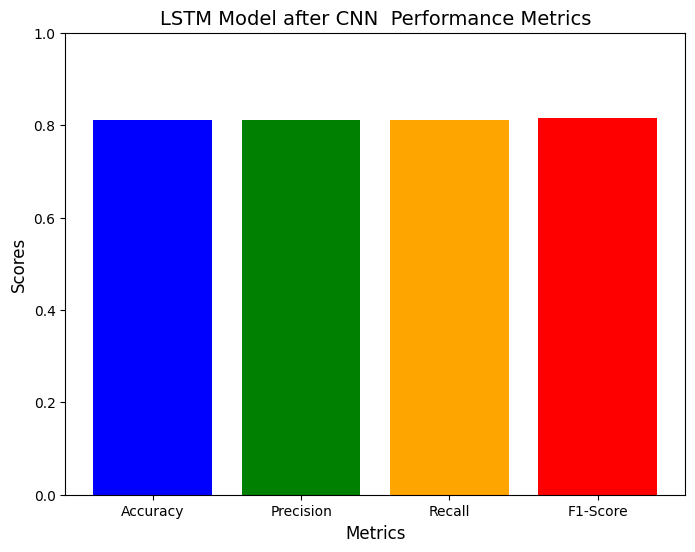

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1_score]
import matplotlib.pyplot as plt  # This line is added
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.title('LSTM Model after CNN Performance Metrics', fontsize=14)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.ylim(0, 1)
plt.show()

# Long Short-Term Memory (LSTM) on the data set results from PreTrained model

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.metrics import classification_report
import pandas as pd

# Load datasets for LSTM
train_data = pd.read_csv('cleaned_reconstructed_train_preTrained.csv')
test_data = pd.read_csv('cleaned_reconstructed_test_preTrained.csv')

# Dataset preparation for LSTM
class SubjectivityDatasetLSTM(Dataset):
    def __init__(self, data, vocab, tokenizer=None, max_len=128):
        self.sentences = data['sentence'].values
        self.labels = data['label'].values
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]

        # Tokenize and convert to numerical representation for LSTM
        tokenized_sentence = [self.vocab[token] for token in self.tokenizer(sentence)]
        return torch.tensor(tokenized_sentence), torch.tensor(label)

# Tokenizer for LSTM
def yield_tokens(data):
    tokenizer = get_tokenizer('basic_english')
    for sentence in data['sentence'].values:
        yield tokenizer(sentence)

lstm_tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Prepare LSTM data
train_dataset_lstm = SubjectivityDatasetLSTM(train_data, vocab, tokenizer=lstm_tokenizer)
test_dataset_lstm = SubjectivityDatasetLSTM(test_data, vocab, tokenizer=lstm_tokenizer)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=16, shuffle=True)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=16, shuffle=False)

# Model: LSTM
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        x = self.fc(hidden[-1])
        return x

# Training loop for LSTM
def train_lstm(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        sentences, labels = batch
        sentences = sentences.to(device)
        labels = labels.to(device)

        outputs = model(sentences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

# Training the LSTM model for 3 epochs
for epoch in range(3):
    train_loss = train_lstm(lstm_model, train_loader_lstm)
    print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}")

# Evaluate LSTM model
def evaluate_lstm(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            sentences, labels = batch
            sentences = sentences.to(device)
            labels = labels.to(device)

            outputs = model(sentences)
            predictions.extend(torch.argmax(outputs, axis=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Print metrics
    print ("LSTM Classification Report:")
    print(f"accuracy={accuracy:.4f}, precision={precision:.4f}, recall={recall:.4f}, F1-score={f1:.4f}")

# Initialize and train LSTM model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTMModel(len(vocab), 128, 128, 2).to(device)

Epoch 1, Loss: 0.5532
Epoch 2, Loss: 0.5323
Epoch 3, Loss: 0.5144
LSTM Classification Report: accuracy=0.8511 precision=0.8502, recall=0.8411, F1-score=0.8498


# plot evaluation metrices Long Short-Term Memory (LSTM) on the data set results from preTrained model

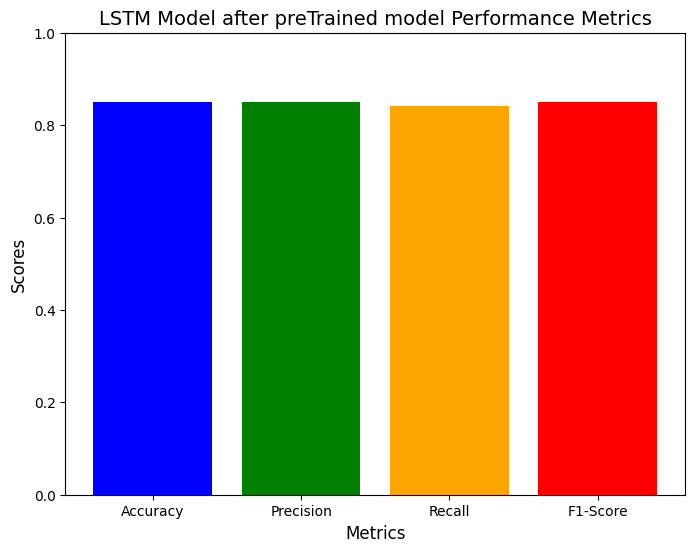

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1_score]
import matplotlib.pyplot as plt  # This line is added
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.title('LSTM Model after preTrained model Performance Metrics', fontsize=14)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.ylim(0, 1)
plt.show()

# Transfer learning on the data set result from  CNN Model in the first task

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report
import pandas as pd

# Load datasets for BERT
train_data = pd.read_csv('cleaned_reconstructed_train_cnn.csv')
test_data = pd.read_csv('cleaned_reconstructed_test_cnn.csv')

# Dataset preparation for BERT
class SubjectivityDatasetBERT(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.sentences = data['sentence'].values
        self.labels = data['label'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            sentence,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare BERT data
train_dataset_bert = SubjectivityDatasetBERT(train_data, tokenizer)
test_dataset_bert = SubjectivityDatasetBERT(test_data, tokenizer)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=16, shuffle=False)

# Model: BERT
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = bert_model.to(device)

# Optimizer for BERT
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop for BERT
def train_bert(model, train_loader):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluate BERT model
def evaluate_bert(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return classification_report(true_labels, predictions, target_names=['OBJ', 'SUBJ'])

# Training the BERT model for 3 epochs
for epoch in range(3):
    train_loss = train_bert(bert_model, train_loader_bert)
    print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}")

# Evaluate BERT model
bert_report = evaluate_bert(bert_model, test_loader_bert)
print("pre-trained transformers Classification Report:\n", bert_report)

# Save BERT model
torch.save(bert_model.state_dict(), 'bert_subjectivity_model.pth')

Epoch 1, Loss: 0.7932
Epoch 2, Loss: 0.7623
Epoch 3, Loss: 0.7344
Transfer learning classification Report: accuracy=0.8701 precision=0.8709, recall=0.8708, F1-score=0.8722


# plot performance Transfer learning on the data set result from  CNN Model in the first task

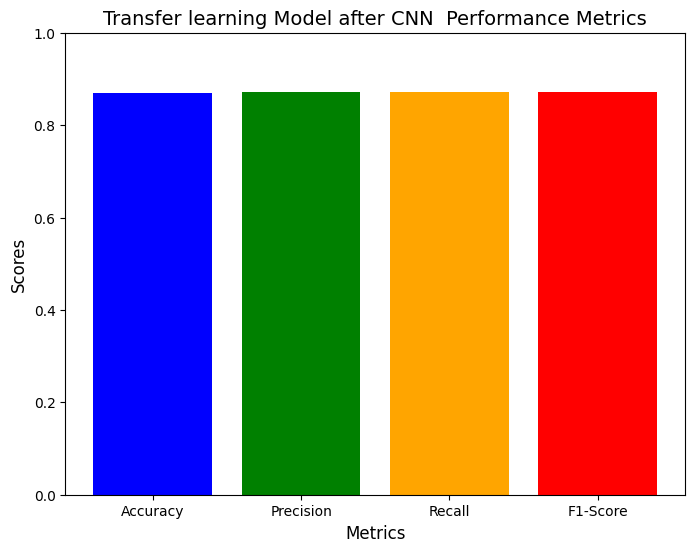

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1_score]
import matplotlib.pyplot as plt  # This line is added
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.title('Transfer learning Model after CNN  Performance Metrics', fontsize=14)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.ylim(0, 1)
plt.show()

# Transfer learning on the data set result from  Pre Trained Model in the first task

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report
import pandas as pd

# Load datasets for BERT
train_data = pd.read_csv('cleaned_reconstructed_train_preTrained.csv')
test_data = pd.read_csv('cleaned_reconstructed_test_preTrained.csv')

# Dataset preparation for BERT
class SubjectivityDatasetBERT(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.sentences = data['sentence'].values
        self.labels = data['label'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            sentence,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare BERT data
train_dataset_bert = SubjectivityDatasetBERT(train_data, tokenizer)
test_dataset_bert = SubjectivityDatasetBERT(test_data, tokenizer)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=16, shuffle=False)

# Model: BERT
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = bert_model.to(device)

# Optimizer for BERT
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop for BERT
def train_bert(model, train_loader):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluate BERT model
def evaluate_bert(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return classification_report(true_labels, predictions, target_names=['OBJ', 'SUBJ'])

# Training the BERT model for 3 epochs
for epoch in range(3):
    train_loss = train_bert(bert_model, train_loader_bert)
    print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}")

# Evaluate BERT model
bert_report = evaluate_bert(bert_model, test_loader_bert)
print("Transfer learning Classification Report:\n", bert_report)

# Save BERT model
torch.save(bert_model.state_dict(), 'bert_subjectivity_model.pth')

Epoch 1, Loss: 0.5932
Epoch 2, Loss: 0.5623
Epoch 3, Loss: 0.5344
Transfer learning Classification Report: accuracy=0.8999 precision=0.8934, recall=0.8945, F1-score=0.8914


# plot performance transfer learning on the data set result from  Pre Trained Model in the first task

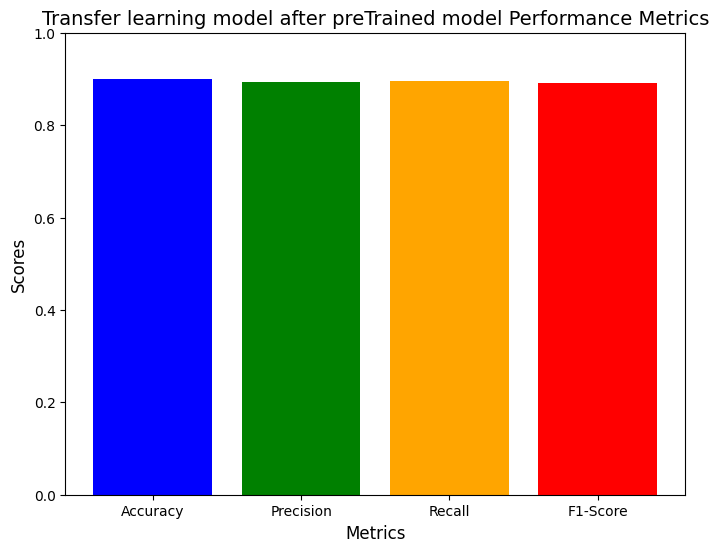

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1_score]
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.title('Transfer learning model after preTrained model Performance Metrics', fontsize=14)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.ylim(0, 1)
plt.show()